# Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans                          # K Means
from sklearn.cluster import AgglomerativeClustering         # Hierarchical Agglomerative Clustering
from sklearn.decomposition import PCA                       # Principal Components Analysis
from sklearn.decomposition import KernelPCA                 # PCA Kernel
from sklearn.decomposition import NMF                       # Non-negative Matrix Factorization
from sklearn.cluster import DBSCAN                          # DBSCAN
from sklearn.manifold import TSNE                           # TSNE
from sklearn.mixture import GaussianMixture                 # GMM
from sklearn.cluster import MeanShift, estimate_bandwidth   # Mean shift
from sklearn.manifold import MDS                            # Multi-Dimensional Scaling

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import RobustScaler, StandardScaler

from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer # count words
from sklearn.preprocessing import scale
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline


In [2]:
data = pd.read_csv("soil.csv")

# EDA

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 673 entries, 0 to 672
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   District   673 non-null    object 
 1   Zn %       658 non-null    float64
 2   Fe%        655 non-null    float64
 3   Cu %       651 non-null    float64
 4   Mn %       651 non-null    float64
 5   B %        608 non-null    float64
 6   S %        663 non-null    float64
dtypes: float64(6), object(1)
memory usage: 36.9+ KB


In [4]:
data = data.dropna()

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 600 entries, 0 to 672
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   District   600 non-null    object 
 1   Zn %       600 non-null    float64
 2   Fe%        600 non-null    float64
 3   Cu %       600 non-null    float64
 4   Mn %       600 non-null    float64
 5   B %        600 non-null    float64
 6   S %        600 non-null    float64
dtypes: float64(6), object(1)
memory usage: 37.5+ KB


In [6]:
data[data.duplicated(subset=['District '], keep=False)]

,District,Zn %,Fe%,Cu %,Mn %,B %,S %
68,Aurangabad,98.48,98.59,99.00,98.54,0.43,0.37
106,Balrampur,88.95,98.74,99.88,97.88,82.22,96.20
109,Bijapur,97.25,96.47,98.79,90.82,88.09,94.71
110,Bilaspur,74.54,96.48,98.45,93.32,86.97,88.01
187,Bilaspur,67.45,92.95,99.71,84.70,99.83,99.77
189,Hamirpur,92.80,86.04,90.88,89.18,96.23,87.97
248,Bijapur,19.36,6.96,93.39,77.45,59.04,10.37
342,Aurangabad,28.16,17.04,98.49,86.72,41.61,93.80
591,Balrampur,97.02,94.00,98.63,97.76,54.41,84.91
613,Hamirpur,66.38,67.04,94.59,79.97,3.08,73.13


In [7]:
data = data.drop([68, 106,109,110,189 ]).reset_index(drop=True)

In [8]:
data[data.duplicated(subset=['District '], keep=False)]

,District,Zn %,Fe%,Cu %,Mn %,B %,S %


In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 595 entries, 0 to 594
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   District   595 non-null    object 
 1   Zn %       595 non-null    float64
 2   Fe%        595 non-null    float64
 3   Cu %       595 non-null    float64
 4   Mn %       595 non-null    float64
 5   B %        595 non-null    float64
 6   S %        595 non-null    float64
dtypes: float64(6), object(1)
memory usage: 32.7+ KB


In [10]:
col_object = data.columns[data.dtypes == "object"].tolist()
col_num = data.columns[(data.dtypes == "int64") | (data.dtypes == "float64")].tolist()

In [11]:
#fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20,5))

#for column, ax in zip(col_object, axes.ravel()):
#    sns.countplot(x=column, data=data, ax=ax, orient="x", order=data[column].value_counts().index)
#    ax.set_title(f'{column}', fontsize=12)
#    ax.tick_params(axis='x', rotation=90, labelsize=9)
#plt.subplots_adjust(hspace=0.4, wspace=0.3)
#plt.show()

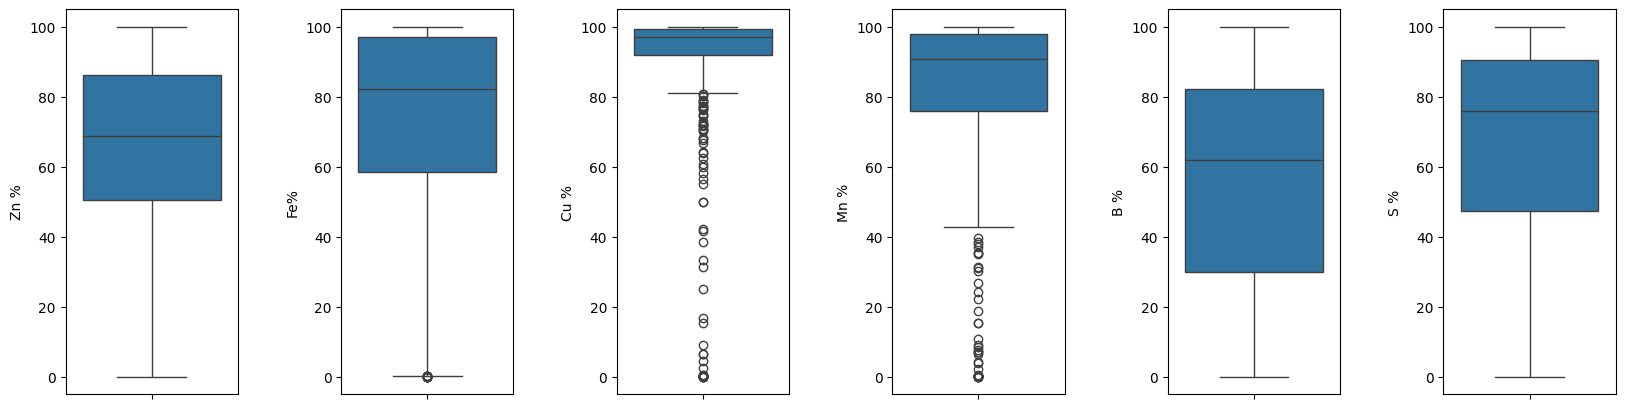

In [12]:
fig, axes = plt.subplots(nrows=1, ncols=len(col_num), figsize=(20,5))

for colum, ax in zip(col_num, axes.ravel()):
    sns.boxplot(data=data[colum], ax=ax)
    #sns.histplot(data.iloc[:,colum], kde=True, ax=ax, bins=20)
    #ax.set_title(f'{colum}', fontsize=12)

plt.subplots_adjust(hspace=0.4, wspace=0.6)

In [13]:
def outliers(colum,bound):

    # Calculate IQR
    Q1 = data[colum].quantile(0.25)
    Q3 = data[colum].quantile(0.75)
    IQR = Q3 - Q1

    # Define bounds
    lower_bound = Q1 - bound * IQR
    upper_bound = Q3 + bound * IQR

    # Identify outliers
    outlier = data[(data[colum] < lower_bound) | (data[colum] > upper_bound)]

    return pd.DataFrame(outlier)

In [109]:
outliers("Cu %", 20)

,District,Zn %,Fe%,Cu %,Mn %,B %,S %


In [110]:
#data = data.drop(110).reset_index(drop=True)

In [14]:
#fig, axes = plt.subplots(nrows=1, ncols=len(col_num), figsize=(20,5))

#for colum, ax in zip(col_num, axes.ravel()):
#    sns.boxplot(data=data[colum], ax=ax)
    #sns.histplot(data.iloc[:,colum], kde=True, ax=ax, bins=20)
    #ax.set_title(f'{colum}', fontsize=12)

#plt.subplots_adjust(hspace=0.4, wspace=0.6)

# Encoded and transform

In [15]:
#encod = OneHotEncoder(drop=None, sparse_output=False)
#encoded_df = encod.fit_transform(data[col_object])
#encoded_df = pd.DataFrame(encoded_df, columns=encod.get_feature_names_out(col_object))
#data_encoded = pd.concat([data.drop(col_object, axis=1), encoded_df], axis=1)

In [18]:
X = data[col_num].copy()

In [19]:
scal = StandardScaler()
scale_df = scal.fit_transform(data[col_num])
X[col_num] = scale_df

In [21]:
X.shape

(595, 6)

# KMeansClustering

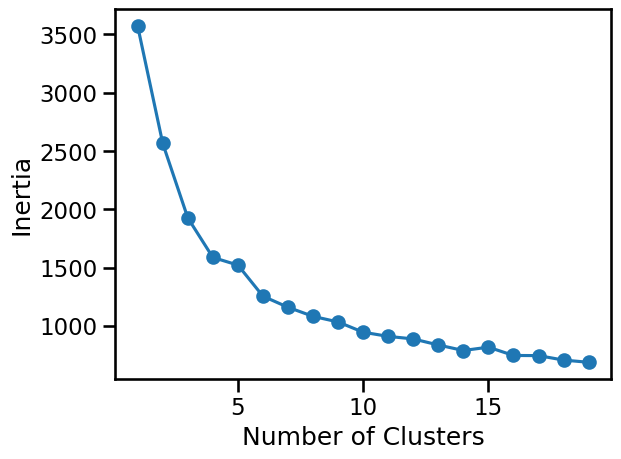

In [52]:
inertia = []
list_num_clusters = list(range(1,20))
for num_clusters in list_num_clusters:
    km = KMeans(n_clusters=num_clusters)
    km.fit(X)
    inertia.append(km.inertia_)
    
plt.plot(list_num_clusters,inertia)
plt.scatter(list_num_clusters,inertia)
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.show()

In [57]:
km = KMeans(n_clusters=6, 
            init="k-means++", 
            max_iter=1000, 
            random_state=24)

km.fit(X)

KMeans(max_iter=1000, n_clusters=6, random_state=24)

In [58]:
data_copy = data.copy()

In [59]:
data_copy['labels_KM'] = km.labels_

# Principal Components Analysis

In [26]:
X.shape

(595, 6)

In [34]:
pca_list = list()
feature_weight_list = list()

# Fit a range of PCA models
for n in range(1, 7):
    
    # Create and fit the model
    PCAmod = PCA(n_components=n)
    PCAmod.fit(X)
    
    # Store the model and variance
    pca_list.append(pd.Series({'n':n, 
                               'model':PCAmod,
                               'var': PCAmod.explained_variance_ratio_.sum()}))
    
    # Calculate and store feature importances
    abs_feature_values = np.abs(PCAmod.components_).sum(axis=0)
    feature_weight_list.append(pd.DataFrame({'n':n, 
                                             'features': X.columns,
                                             'values':abs_feature_values/abs_feature_values.sum()}))
    
pca_df = pd.concat(pca_list, axis=1).T.set_index('n')
features_df = (pd.concat(feature_weight_list)
               .pivot(index='n', columns='features', values='values'))

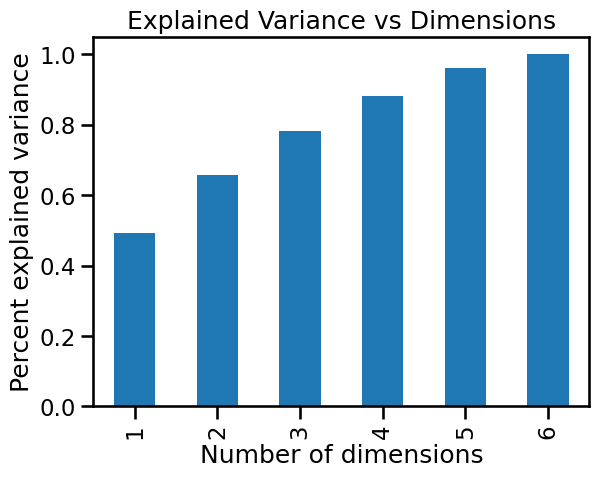

In [35]:
sns.set_context('talk')
ax = pca_df['var'].plot(kind='bar')

ax.set(xlabel='Number of dimensions',
       ylabel='Percent explained variance',
       title='Explained Variance vs Dimensions')
plt.show()

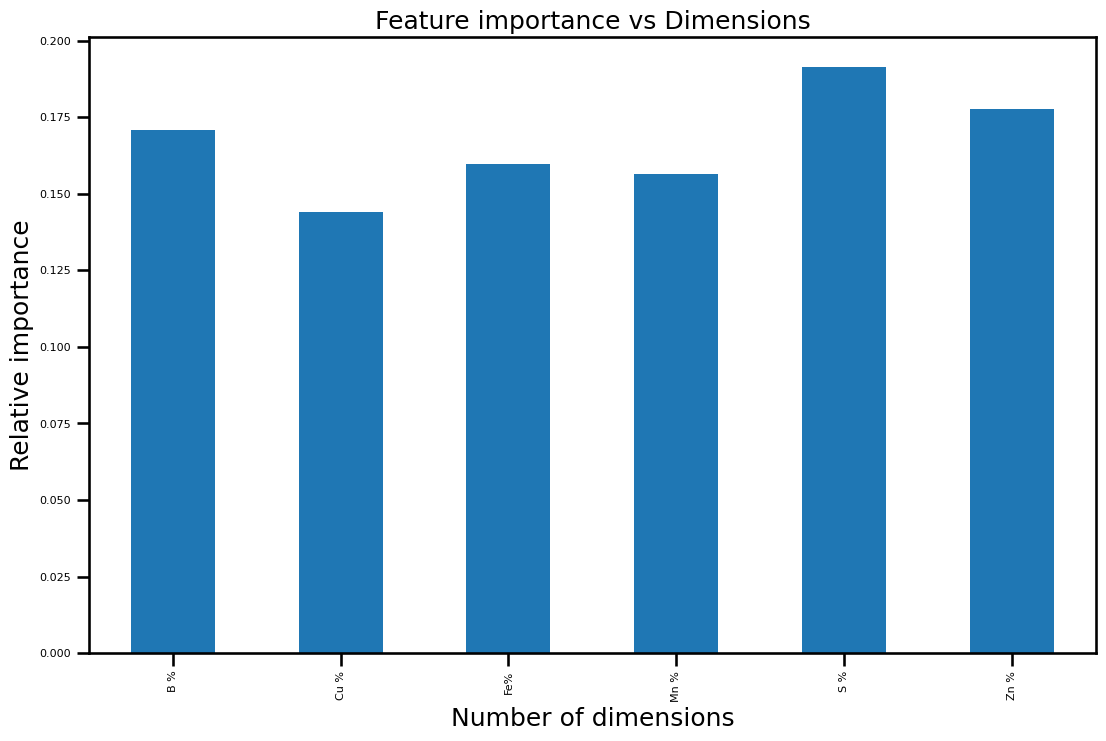

In [112]:
ax = features_df.iloc[4,:].plot(kind='bar', figsize=(13,8))
#ax.legend(loc='upper right')
ax.set(xlabel='Number of dimensions',
       ylabel='Relative importance',
       title='Feature importance vs Dimensions')
ax.tick_params(labelsize=8)
plt.show()

In [47]:
#pca_data = PCAmod.transform(X)
#df_pca = {}
#for i in range(6):
#    df_pca['col_'+str(i)] = pca_data[:,i]
#df_pca = pd.DataFrame(df_pca)

In [53]:
#inertia = []
#list_num_clusters = list(range(1,20))
#for num_clusters in list_num_clusters:
#    km = KMeans(n_clusters=num_clusters)
#    km.fit(df_pca)
#    inertia.append(km.inertia_)
    
#plt.plot(list_num_clusters,inertia)
#plt.scatter(list_num_clusters,inertia)
#plt.xlabel('Number of Clusters')
#plt.ylabel('Inertia')
#plt.show()

In [30]:
#data_encoded.to_csv("data_encoded.csv", index=False)
#data_copy.to_csv("data_copy.csv", index=False)
#df_pca.to_csv("data_pca.csv", index=False)

# PCA Kernel

In [91]:
kernel_pca = KernelPCA(n_components=20, kernel="rbf", gamma=10, fit_inverse_transform=True, alpha=0.1)

In [92]:
kernel_pca.fit(X)

KernelPCA(alpha=0.1, fit_inverse_transform=True, gamma=10, kernel='rbf',
          n_components=20)

In [93]:
X_pca_kernel = kernel_pca.transform(X)

In [98]:
df_pca_kernel = {}
for i in range(X_pca_kernel.shape[1]):
    df_pca_kernel['col_'+str(i)] = X_pca_kernel[:,i]
X_pca_kernel = pd.DataFrame(df_pca_kernel)

aplica primero pca y luego los algoritmos de clasificacion, variando cada uno con las metricas generales o especficas

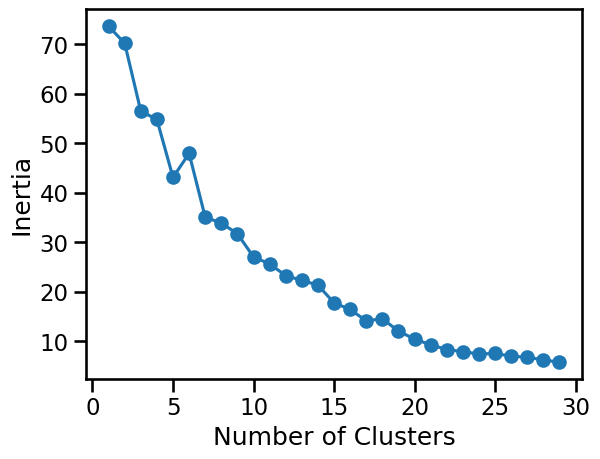

In [100]:
inertia = []
list_num_clusters = list(range(1,30))
for num_clusters in list_num_clusters:
    km = KMeans(n_clusters=num_clusters)
    km.fit(X_pca_kernel)
    inertia.append(km.inertia_)
    
plt.plot(list_num_clusters,inertia)
plt.scatter(list_num_clusters,inertia)
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.show()

# DBSCAN

In [102]:
cluster = DBSCAN(eps=3, min_samples=4)
cluster.fit(X)

DBSCAN(eps=3, min_samples=4)

In [104]:
data_copy["label_BDS"] = cluster.labels_

# GMM

In [105]:
GMM = GaussianMixture(n_components=3, random_state=10)
GMM.fit(X)

GaussianMixture(n_components=3, random_state=10)

In [107]:
data_copy["label_GMM"] = GMM.predict(X)

# Mean shift

In [108]:
bandwidth = estimate_bandwidth(X, quantile=.06, n_samples=3000)
bandwidth 

np.float64(1.5690672231839131)

In [109]:
ms = MeanShift(bandwidth=bandwidth,bin_seeding=True)
ms.fit(X)

MeanShift(bandwidth=np.float64(1.5690672231839131), bin_seeding=True)

In [110]:
data_copy["ms"] = ms.labels_

In [111]:
data_copy

,District,Zn %,Fe%,Cu %,Mn %,B %,S %,labels_KM,label_BDS,label_GMM,ms
0,Anantapur,67.67,65.14,91.88,77.70,73.54,85.90,0,0,0,0
1,Chittoor,80.51,78.19,99.77,91.82,89.04,88.62,0,0,1,0
2,East Godavari,79.27,88.14,95.54,97.24,88.05,95.67,0,0,1,0
3,Guntur,58.30,71.16,98.86,91.40,86.15,86.81,2,0,1,0
4,Krishna,78.62,82.02,98.05,95.23,65.78,98.56,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...
590,Birbhum,93.95,100.00,98.63,97.06,78.52,22.07,0,0,1,0
591,KALIMPONG,100.00,100.00,100.00,84.81,100.00,62.50,0,0,1,0
592,Maldah,98.56,93.78,97.61,68.60,81.34,44.98,0,0,0,0
593,Murshidabad,96.36,99.59,100.00,94.31,87.85,36.84,0,0,1,0


# ver las metricas

In [ ]:
from sklearn.metrics import silhouette_score

score = silhouette_score(X, labels)  # labels from your clustering algorithm
from sklearn.metrics import calinski_harabasz_score

score = calinski_harabasz_score(X, labels)
from sklearn.mixture import GaussianMixture
import numpy as np

bic = []
aic = []
n_components = range(1, 10)  # Test 1 to 10 clusters
for n in n_components:
    gmm = GaussianMixture(n_components=n).fit(X)
    bic.append(gmm.bic(X))
    aic.append(gmm.aic(X))

# You can plot the BIC/AIC values to find the optimal number of clusters

